In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use('seaborn-v0_8-notebook')
pd.options.display.max_rows = 10
plt.rcParams["figure.figsize"]=(12,6)

In [12]:
ny_pois_ids = np.loadtxt("NYC_POIs/ny_municipality_pois_id.csv")

d_types = {
    '@type':str,
    '@lat':float,
    '@lon':float,
    'amenity': str,
    'name': str,
    'shop': str,
    'public_transport': str,
    'highway': str
}

all_pois_df = pd.read_csv("pois_all_info", sep='\t', index_col='@id', dtype=d_types)

# To filter we can use the loc method
pois_df = all_pois_df.loc[ny_pois_ids]

In [13]:
pois_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53550 entries, 42432939 to 6146672068
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   @type             53550 non-null  object 
 1   @lat              53550 non-null  float64
 2   @lon              53550 non-null  float64
 3   amenity           24712 non-null  object 
 4   name              30550 non-null  object 
 5   shop              8717 non-null   object 
 6   public_transport  8376 non-null   object 
 7   highway           7559 non-null   object 
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


In [14]:
pois_df.describe()

,@lat,@lon
count,53550.000000,53550.000000
mean,40.720742,-73.936320
std,0.065739,0.078965
min,40.502423,-74.252791
25%,40.679971,-73.987065
50%,40.721492,-73.955369
75%,40.760094,-73.893479
max,40.913907,-73.700112


In [19]:
def get_categories():
    return ['amenity', 'shop', 'public_transport', 'highway']

def get_top_perc(series, perc_value=.8):
    perc = series.cumsum() / series.sum()
    arg = (perc > perc_value).values.argmax()
    return series.iloc[:arg+1]


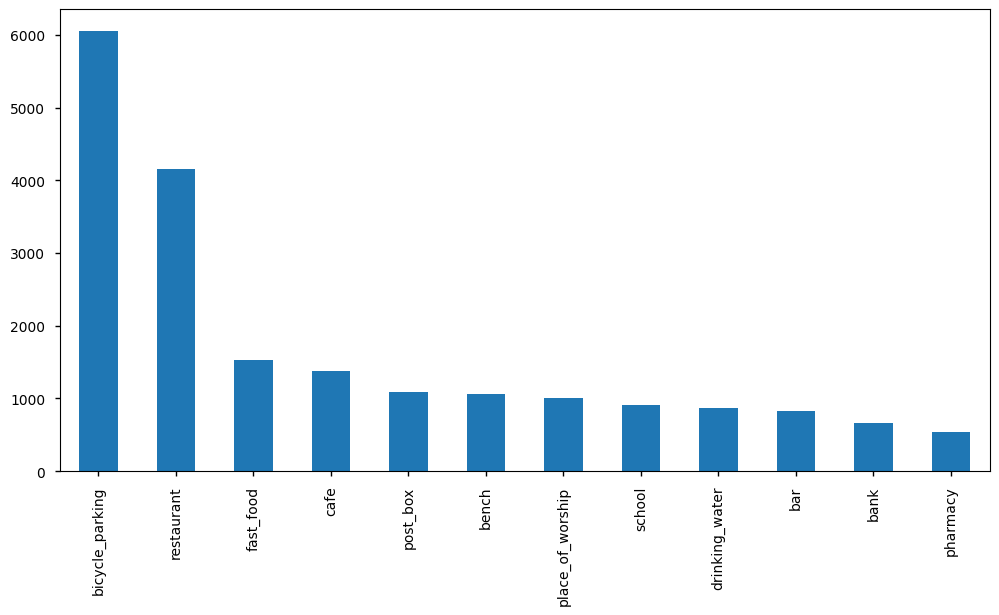

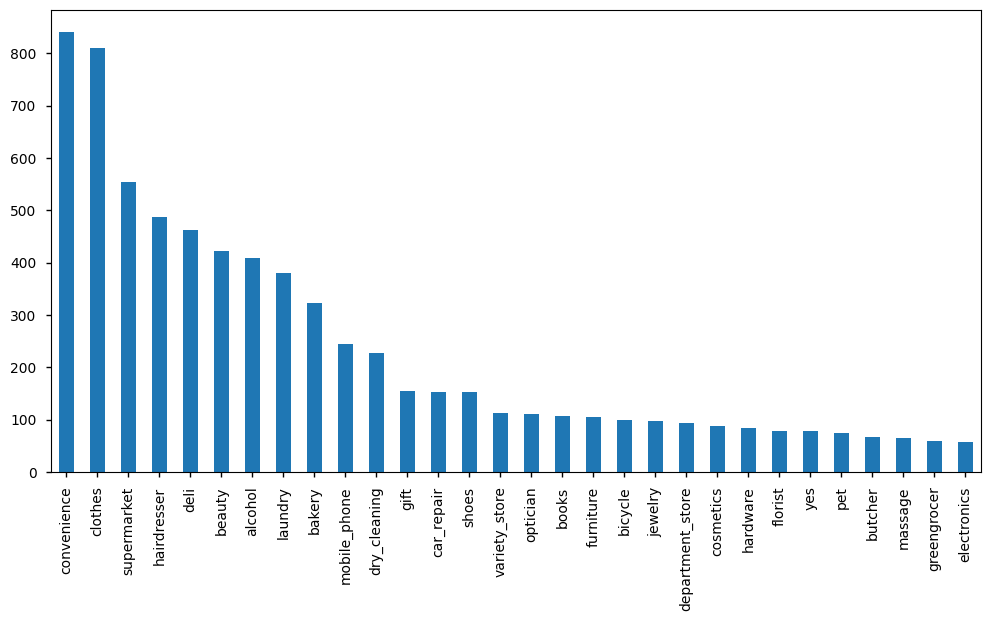

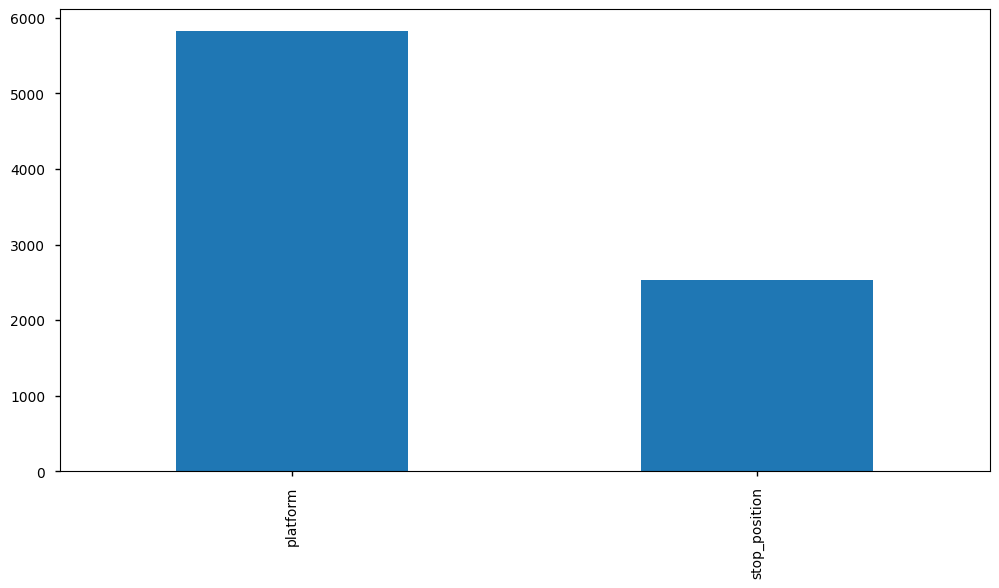

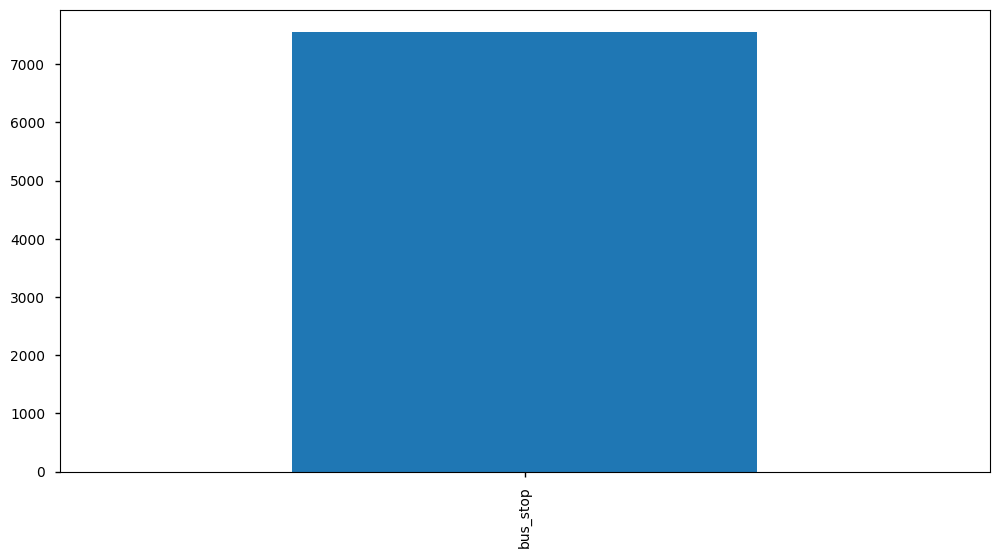

In [20]:
for col in get_categories():
    p = .8
    valc = pois_df[col].value_counts()
    valf = get_top_perc(valc, p)
    fig, ax = plt.subplots()
    valf.plot(kind='bar', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [24]:
from matplotlib.cm import get_cmap
class Map:
    def __init__(self, df) -> None:
        self.pois_df = df
        self.lat_min = df['@lat'].min()
        self.lat_max = df['@lat'].max()
        self.lon_max = df['@lon'].max()
        self.lon_min = df['@lon'].min()
    
    def plot_map(self):
        fig, ax = plt.subplots()
        nyc_img = plt.imread("NYC_POIs/New_York_City_Map.PNG")
        ax.imshow(nyc_img, zorder=0, extent=[self.lon_min, self.lon_max, self.lat_min, self.lat_max])
        ax.grid(False)
        return ax
    
    def plot_pois(self, ax, category, mask):
        df = self.pois_df.loc[mask]
        types = df[category].unique()
        cmap = get_cmap('viridis')
        colors = cmap(np.linspace(0,1,types.size))
        for i, t in enumerate(types):
            df_t = df.loc[df[category] == t]
            c = [colors[i]] * df_t.shape[0]
            df_t.plot.scatter(x='@lon', y='@lat', ax=ax, c=c, alpha=.6, label=t)
        ax.legend()
        ax.grid(False)
        return ax



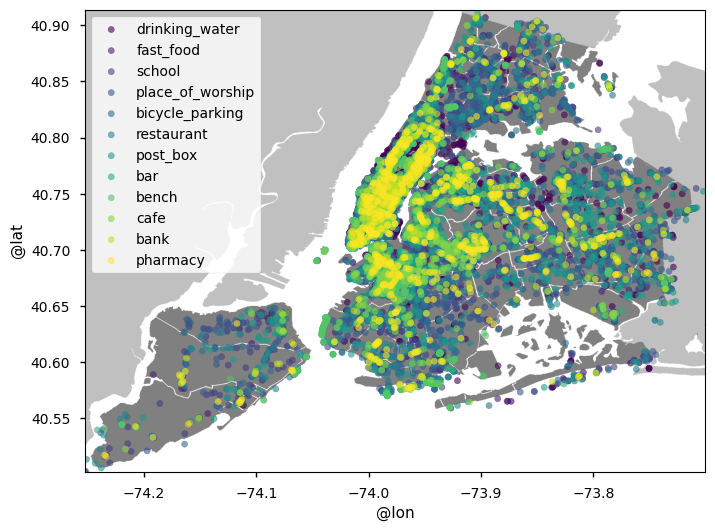

In [25]:
def show_category_on_map(df, column, perc_value):
    counts = df[column].value_counts()
    top_freq = get_top_perc(counts, perc_value)
    ny_map = Map(df)

    ax = ny_map.plot_map()
    mask = df[column].isin(top_freq.index)
    ny_map.plot_pois(ax, column, mask)

show_category_on_map(pois_df, 'amenity', .8)


In [31]:
class Cell_converter:
    def __init__(self, df, n_splits):
        self.lat_min = df['@lat'].min()
        self.lat_max = df['@lat'].max()
        self.long_min = df['@lon'].min()
        self.long_max = df['@lon'].max()
        self.n_splits = n_splits
    
    def plot_grid(self, ax):
        lat_steps = np.linspace(self.lat_min, self.lat_max, self.n_splits + 1)
        long_steps = np.linspace(self.long_min, self.long_max, self.n_splits + 1)
        ax.hlines(lat_steps, self.long_min, self.long_max)
        ax.vlines(long_steps, self.lat_min, self.lat_max)
    
    def point_to_cell_coord(self, long, lat):
        x = int((long - self.long_min)/(self.long_max - self.long_min)*self.n_splits)
        y = int((lat - self.lat_min)/(self.lat_max - self.lat_min)*self.n_splits)
        return x, y
    
    def point_to_cell_id(self, long, lat):
        x, y = self.point_to_cell_coord(long, lat)
        return y * n_splits + x

n_splits = 20
cell_conv = Cell_converter(pois_df, n_splits)

pois_df['cell_id'] = pois_df.apply(lambda x: cell_conv.point_to_cell_id(x['@lon'], x['@lat']), axis=1)
pois_df.head()

,@type,@lat,@lon,amenity,name,shop,public_transport,highway,cell_id
@id,,,,,,,,,
42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN,310
42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN,250
42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN,337
42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN,353
42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN,197


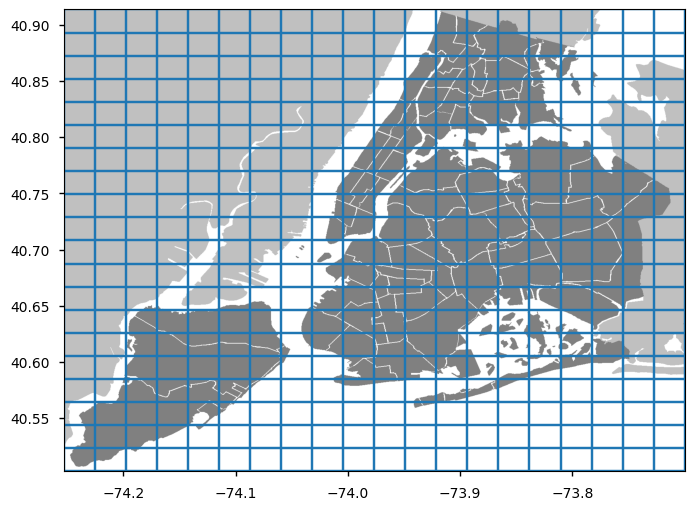

In [30]:
another_map = Map(pois_df)
ax = another_map.plot_map()
cell_conv.plot_grid(ax)


In [34]:
def get_df_count(df, column, perc_value):
    counts = df[column].value_counts()
    top_freq = get_top_perc(counts, perc_value)
    mask = df[column].isin(top_freq.index)
    freq_df = df.loc[mask]

    # for each cell_id count the number of POIs for each type
    count_dframe = []
    for cell_id in range(n_splits**2):
        count_vals = freq_df.loc[freq_df['cell_id'] == cell_id][column].value_counts()
        count_vals.name = cell_id
        count_dframe.append(count_vals)

    cells_features_df = pd.DataFrame(count_dframe)
    cells_features_df = cells_features_df.fillna(0)
    return cells_features_df

amenities_df = get_df_count(pois_df, 'amenity', .6)
amenities_df.head()

,restaurant,post_box,fast_food,bicycle_parking,cafe,bench
0,2.0,2.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
shops_df = get_df_count(pois_df, 'shop', .6)
shops_df.head()

,supermarket,convenience,gift,alcohol,clothes,bakery,beauty,laundry,hairdresser,deli,mobile_phone,dry_cleaning
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
final_df = pd.concat([amenities_df, shops_df], axis=1)
final_df.head()

,restaurant,post_box,fast_food,bicycle_parking,cafe,bench,supermarket,convenience,gift,alcohol,clothes,bakery,beauty,laundry,hairdresser,deli,mobile_phone,dry_cleaning
0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_corr = final_df.corr()
final_corr.head()

,restaurant,post_box,fast_food,bicycle_parking,cafe,bench,supermarket,convenience,gift,alcohol,clothes,bakery,beauty,laundry,hairdresser,deli,mobile_phone,dry_cleaning
restaurant,1.000000,0.738146,0.892643,0.933327,0.977129,0.325605,0.854280,0.698709,0.748171,0.893299,0.897885,0.934591,0.641513,0.533456,0.702188,0.527927,0.697886,0.779390
post_box,0.738146,1.000000,0.791383,0.757908,0.751239,0.464872,0.831700,0.732534,0.572624,0.854463,0.640424,0.730414,0.744983,0.700626,0.764960,0.669046,0.747977,0.802623
fast_food,0.892643,0.791383,1.000000,0.823712,0.931877,0.463410,0.762383,0.707077,0.808271,0.856165,0.790148,0.759500,0.726217,0.557794,0.758824,0.574192,0.776886,0.822514
bicycle_parking,0.933327,0.757908,0.823712,1.000000,0.922268,0.381228,0.858209,0.633704,0.662442,0.873462,0.839809,0.888446,0.673453,0.522363,0.745809,0.490781,0.607225,0.793769
cafe,0.977129,0.751239,0.931877,0.922268,1.000000,0.407526,0.813572,0.694446,0.786491,0.901696,0.875035,0.874180,0.657689,0.508593,0.732542,0.480233,0.690048,0.813883


<AxesSubplot: >

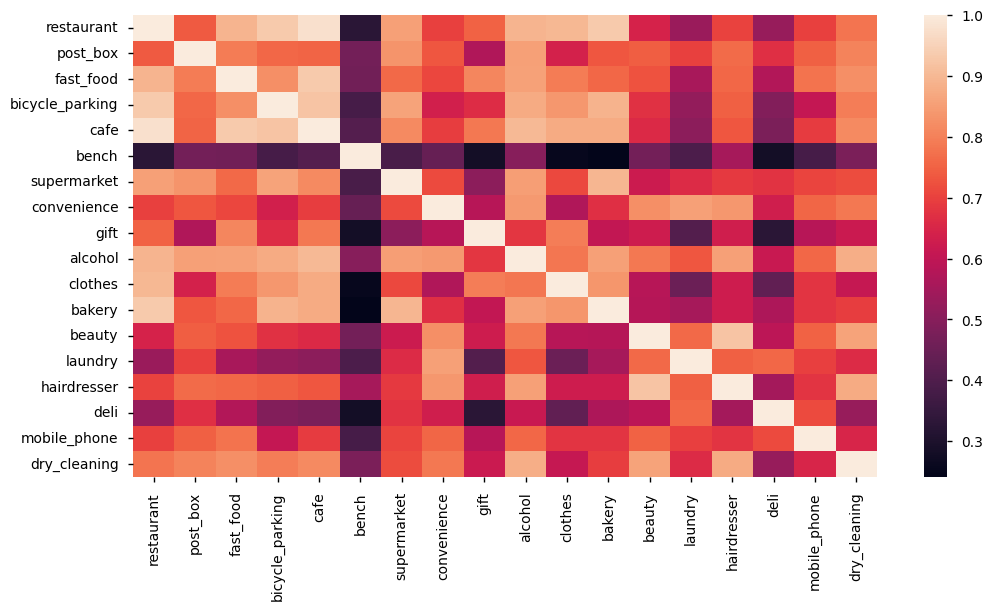

In [39]:
import seaborn as sns
sns.heatmap(final_corr)

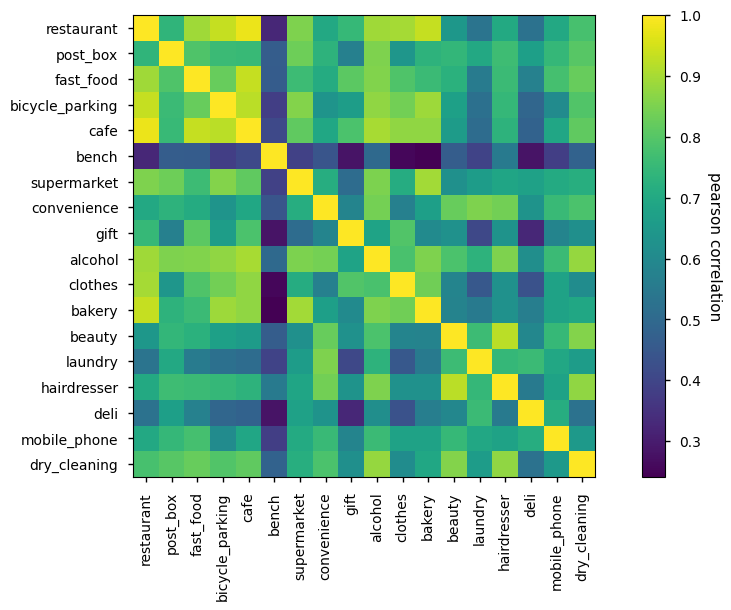

In [40]:
fig, ax = plt.subplots()
im = ax.imshow(final_corr)
ax.set_xticks(np.arange(final_corr.columns.size))
ax.set_yticks(np.arange(final_corr.columns.size))
ax.set_xticklabels(final_corr.columns)
ax.set_yticklabels(final_corr)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va="center",
         rotation_mode="anchor") # rotate labels on x-axis
cbar = ax.figure.colorbar(im, ax=ax)
_ = cbar.ax.set_ylabel('pearson correlation', rotation=-90, va="bottom")